In [1]:
!pip install opencv-python==4.5.5.64
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import os 
os.chdir('../src')

In [3]:
from envs.env_dataloader import create_dataloaders
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchmetrics.image import StructuralSimilarityIndexMeasure
from envs.new_edit_photo import PhotoEditor
from sac.sac_inference import InferenceAgent
import yaml
from envs.photo_env import PhotoEnhancementEnvTest
import numpy as np
import argparse
import logging
import os
from pathlib import Path
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DEVICE = 'cuda:12'
class Config(object):
    def __init__(self, dictionary):
        self.__dict__.update(dictionary)

with open(os.path.join("configs/inference_config.yaml")) as f:
    inf_config_dict =yaml.load(f, Loader=yaml.FullLoader)
inference_config = Config(inf_config_dict)
inference_config.device = DEVICE

In [5]:
experiments_path = '../experiments/runs/'
models_path = [os.path.join(experiments_path,model_path) for model_path in os.listdir(experiments_path)]

In [6]:
models_path.remove('../experiments/runs/ResNetEncoder__1__1720274282')
models_path.remove('../experiments/runs/ResNetEncoder__1__1719841165')
models_path = models_path[:-1]

In [7]:
models_names = [name.split('/')[-1] for name in models_path]

In [8]:
models_names

['ResNetEncoder__fiveslidersaug__2024-07-12_14-59-37',
 'ResNetEncoder__fivesliders__2024-07-10_15-57-44',
 'ResNetEncoder__allsliders__2024-07-09_16-04-37',
 'ResNetEncoder__solos__2024-07-08_14-39-07',
 'ResNetEncoder__sixsliders__2024-07-11_21-02-42',
 'ResNetEncoder__ninesliders__2024-07-11_22-58-05']

In [9]:
all_psnrs = []
all_ssims = []
for model_path in models_path:
    with open(os.path.join(model_path,"configs/sac_config.yaml")) as f:
        sac_config_dict =yaml.load(f, Loader=yaml.FullLoader)
    with open(os.path.join(model_path,"configs/env_config.yaml")) as f:
        env_config_dict =yaml.load(f, Loader=yaml.FullLoader)

    sac_config = Config(sac_config_dict)
    env_config = Config(env_config_dict)
    sac_config.device = DEVICE

    photo_editor = PhotoEditor(env_config.sliders_to_use)

    inference_env = PhotoEnhancementEnvTest(
                        batch_size=inference_config.batch_size,
                        imsize=inference_config.imsize,
                        training_mode=False,
                        done_threshold=inference_config.threshold_psnr,
                        pre_encode=False,
                        edit_sliders=env_config.sliders_to_use,
                        features_size=inference_config.features_size,
                        discretize=env_config.discretize,
                        discretize_step= env_config.discretize_step,
                        logger=None)

    inf_agent =InferenceAgent(inference_env, inference_config)
    inf_agent.load_backbone(os.path.join(model_path,'models','backbone.pth'))
    inf_agent.load_actor_weights(os.path.join(model_path,'models','actor_head.pth'))
    inf_agent.load_critics_weights( os.path.join(model_path,'models','qf1_head.pth'), os.path.join(model_path,'models','qf2_head.pth'))

    ssim_metric = StructuralSimilarityIndexMeasure()
    test_512 = create_dataloaders(batch_size=1,image_size=64,train=False,pre_encode= False,shuffle=False,resize=False)
    transform = transforms.Compose([
                v2.Resize(size = (64,64), interpolation= transforms.InterpolationMode.BICUBIC),
            ])
    PSNRS = []
    SSIM = []
    for i,t in tqdm(test_512, position=0, leave=True):
        source = i/255.0
        target = t/255.0 
        parameters = inf_agent.act(obs=transform(source),deterministic=True)
        enhanced_image = photo_editor((source.permute(0,2,3,1)).cpu(),parameters[0].cpu())
        psnr = inference_env.compute_rewards(enhanced_image.permute(0,3,1,2),target).item()+50
        ssim = ssim_metric(enhanced_image.permute(0,3,1,2),target).item()
        PSNRS.append(psnr)
        SSIM.append(ssim)
    mean_PSNRS = round(np.mean(PSNRS),2)
    mean_SSIM = round(np.mean(SSIM),3)
    all_psnrs.append(mean_PSNRS)
    all_ssims.append(mean_SSIM)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:42<00:00,  2.25it/s]


In [12]:
all_ssims

[0.84, 0.805, 0.818, 0.836, 0.835, 0.69]

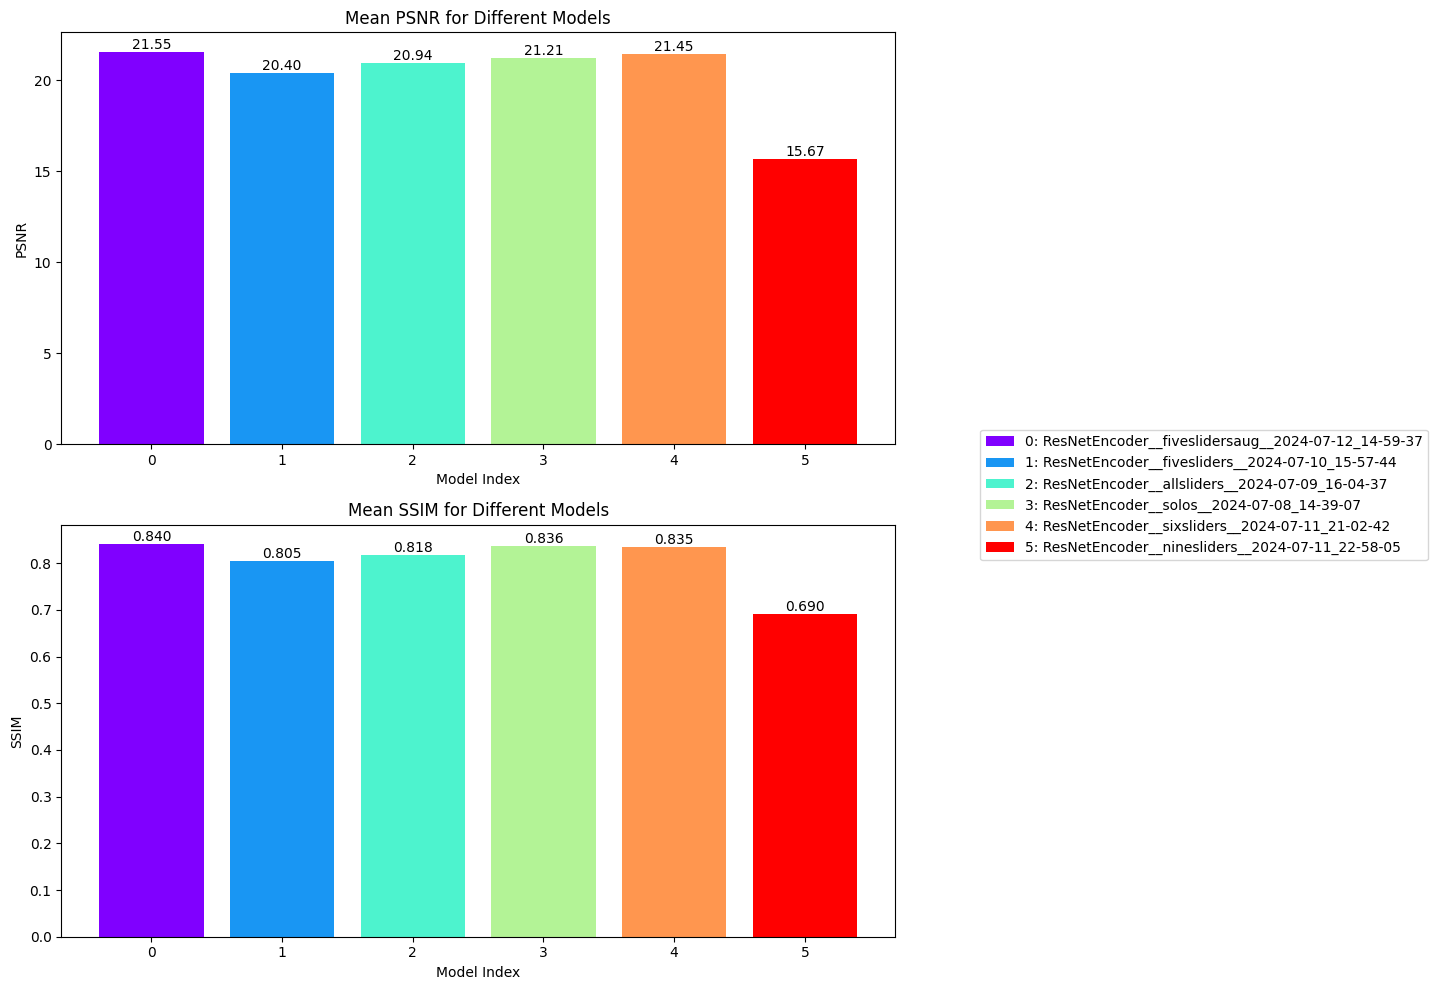

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_psnrs, all_ssims, and models_names are already defined
# and models_names[:-1] is used to exclude the last model

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Generate indices for x-axis
indices = range(len(models_names))

# Generate a colormap
colors = plt.cm.rainbow(np.linspace(0, 1, len(indices)))

# PSNR plot
bars1 = ax1.bar(indices, all_psnrs, color=colors)
ax1.set_title('Mean PSNR for Different Models')
ax1.set_xlabel('Model Index')
ax1.set_ylabel('PSNR')
ax1.set_xticks(indices)

# Add value labels on the bars for PSNR
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# SSIM plot
bars2 = ax2.bar(indices, all_ssims, color=colors)
ax2.set_title('Mean SSIM for Different Models')
ax2.set_xlabel('Model Index')
ax2.set_ylabel('SSIM')
ax2.set_xticks(indices)

# Add value labels on the bars for SSIM
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# Create legend
legend_labels = [f"{i}: {name}" for i, name in enumerate(models_names)]
fig.legend(bars1, legend_labels, loc='center right', bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.subplots_adjust(right=0.75)  # Adjust this value to make room for the legend
plt.show()

In [15]:
import cv2
import torch
import matplotlib.pyplot as plt
source_image = cv2.imread("sample_images/a0676-kme_609_original.jpg")
target_image = cv2.imread("sample_images/a0676-kme_609_C.jpg")
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB) /255.0
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB) /255.0
source_input = torch.Tensor(source_image).unsqueeze(0)
target_input = torch.Tensor(target_image).unsqueeze(0)
param_UIE = torch.tensor([0.125, 0.125, 0.375, 0.125, 0., 0.0625, 0.9375, 0.375, 0.0625, 0., 0.125, 0.125]).unsqueeze(0)

In [16]:
indicies = [(i,j) for i in range(3) for j in range(3)]
indicies.remove((2, 2))
indicies.remove((0, 0))
indicies.remove((2, 1))

In [18]:
source_input.shape

torch.Size([1, 512, 340, 3])

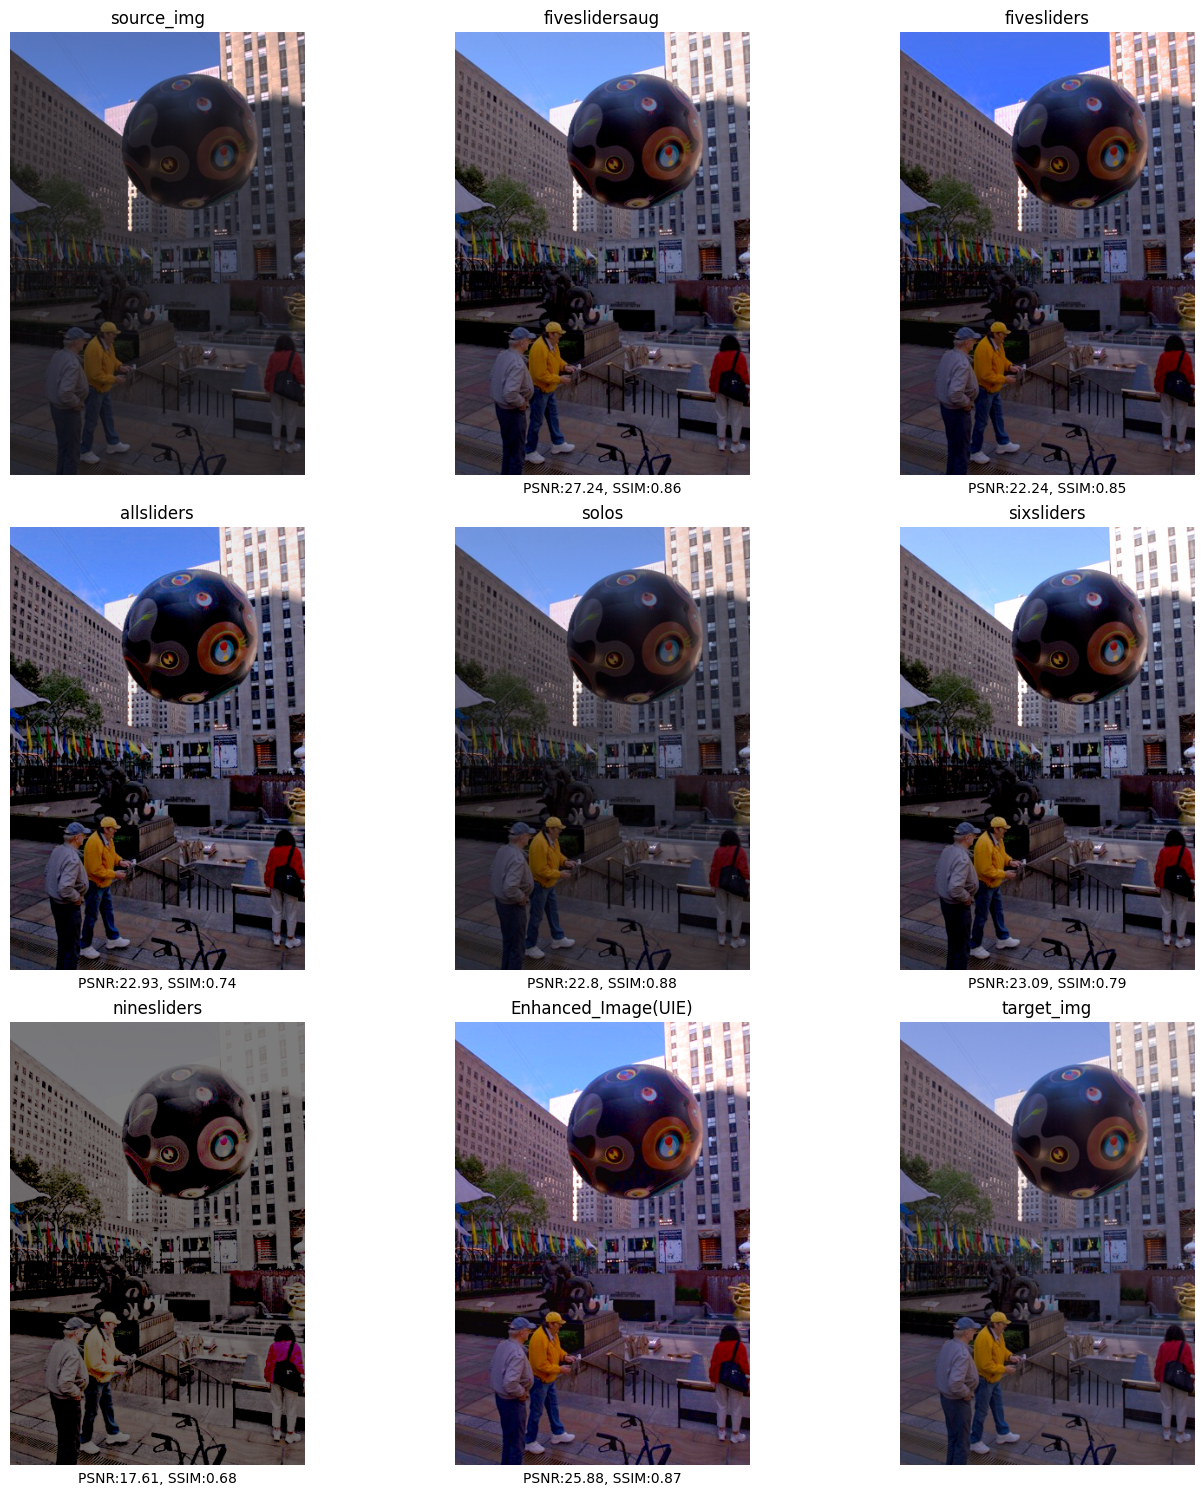

In [19]:
transform = transforms.Compose([
                v2.Resize(size = (64,64), interpolation= transforms.InterpolationMode.BICUBIC),
            ])

fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Increased figure size
plt.subplots_adjust(hspace=0.5)
axes[0][0].imshow(source_image)
axes[0][0].set_title(('source_img'))
axes[0][0].axis('off')

axes[2][2].imshow(target_image)
axes[2][2].set_title(('target_img'))
axes[2][2].axis('off')

for index,model_path, in zip(indicies,models_path):
    with open(os.path.join(model_path,"configs/sac_config.yaml")) as f:
        sac_config_dict =yaml.load(f, Loader=yaml.FullLoader)
    with open(os.path.join(model_path,"configs/env_config.yaml")) as f:
        env_config_dict =yaml.load(f, Loader=yaml.FullLoader)

    sac_config = Config(sac_config_dict)
    env_config = Config(env_config_dict)
    sac_config.device = DEVICE
    label = model_path.split('/')[-1].split('__')[1]
    photo_editor = PhotoEditor(env_config.sliders_to_use)

    inference_env = PhotoEnhancementEnvTest(
                        batch_size=inference_config.batch_size,
                        imsize=inference_config.imsize,
                        training_mode=False,
                        done_threshold=inference_config.threshold_psnr,
                        pre_encode=False,
                        edit_sliders=env_config.sliders_to_use,
                        features_size=inference_config.features_size,
                        discretize=env_config.discretize,
                        discretize_step= env_config.discretize_step,
                        logger=None)

    inf_agent =InferenceAgent(inference_env, inference_config)
    inf_agent.load_backbone(os.path.join(model_path,'models','backbone.pth'))
    inf_agent.load_actor_weights(os.path.join(model_path,'models','actor_head.pth'))
    inf_agent.load_critics_weights( os.path.join(model_path,'models','qf1_head.pth'), os.path.join(model_path,'models','qf2_head.pth'))

    ssim_metric = StructuralSimilarityIndexMeasure()
    test_512 = create_dataloaders(batch_size=1,image_size=64,train=False,pre_encode= False,shuffle=False,resize=False)
    
    transformed_input = transform(source_input.permute(0,3,1,2))
    parameters = inf_agent.act(obs=transformed_input,deterministic=False)
    enhanced_image = photo_editor(source_input.cpu(),parameters[0].cpu())

    psnr = inference_env.compute_rewards(enhanced_image.permute(0,3,1,2),target_input.permute(0,3,1,2) ).item()+50
    ssim = ssim_metric(enhanced_image.permute(0,3,1,2),target_input.permute(0,3,1,2)).item()
    
    axes[index[0]][index[1]].imshow(enhanced_image[0])
    axes[index[0]][index[1]].set_title(label)
    axes[index[0]][index[1]].axis('off')
    axes[index[0]][index[1]].text(0.5, -0.04, f'PSNR:{round(psnr,2)}, SSIM:{round(ssim,2)}', size=10, ha='center', 
                                  transform=axes[index[0]][index[1]].transAxes) 
    
inference_env = PhotoEnhancementEnvTest(
                    batch_size=inference_config.batch_size,
                    imsize=inference_config.imsize,
                    training_mode=False,
                    done_threshold=inference_config.threshold_psnr,
                    pre_encode=False,
                    edit_sliders='all',
                    features_size=inference_config.features_size,
                    discretize=False,
                    discretize_step= env_config.discretize_step,
                    logger=None)

photo_editor = PhotoEditor('all')
ssim_metric = StructuralSimilarityIndexMeasure()

enhanced_image = photo_editor(source_input.cpu(),
                              param_UIE.cpu())
psnr = inference_env.compute_rewards(enhanced_image.permute(0,3,1,2),target_input.permute(0,3,1,2) ).item()+50
ssim = ssim_metric(enhanced_image.permute(0,3,1,2),target_input.permute(0,3,1,2)).item()

axes[2][1].imshow(enhanced_image[0])
axes[2][1].set_title(("Enhanced_Image(UIE)"))
axes[2][1].axis('off')
axes[2][1].text(0.5, -0.04, f'PSNR:{round(psnr,2)}, SSIM:{round(ssim,2)}', size=10, ha='center', 
                                  transform=axes[2][1].transAxes) 
for i in range(3):
    for j in range(3):
        if not axes[i][j].has_data():
            fig.delaxes(axes[i][j])

plt.tight_layout()
plt.show()